In [1]:
# import packages
import numpy as np
import pandas as pd
import nltk
from bertopic import BERTopic
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import umap as UMAP
from hdbscan import HDBSCAN
from collections import Counter
import math
import matplotlib.pyplot as plt
from wordcloud import WordCloud

/Users/zara/Documents/GitHub/news-bias-detection/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'wordcloud'

In [18]:
!pip install hdbscan

In [37]:
# import dataset
df = pd.read_csv("../datasets/news_dataset_headlines_cleaned.csv")
df.head()

,outlet,headline,nlp_label,nlp-image_label,headline_words,headline_sentence
0,CBC.ca,"Tij Iginla embraces family name, eager to foll...",Likely to be Bias,Likely to be Unbiased,"['tij', 'iginla', 'embrace', 'family', 'name',...",tij iginla embrace family name eager follow ha...
1,CBC.ca,"The Sunday Magazine for June 23, 2024 - CBC.ca",Likely to be Bias,Likely to be Unbiased,"['sunday', 'magazine', 'june']",sunday magazine june
2,CBC News,"Conservative MP shares inaccurate, ChatGPT-gen...",Likely to be Bias,Likely to be Bias,"['conservative', 'mp', 'share', 'inaccurate', ...",conservative mp share inaccurate stats capital...
3,CBC.ca,"Women's sports are more popular than ever, but...",Likely to be Unbiased,Likely to be Unbiased,"['woman', 'sport', 'popular', 'ever', 'study',...",woman sport popular ever study female physiolo...
4,CBC.ca,June 22: Listener Question Show - CBC.ca,Likely to be Bias,Likely to be Unbiased,"['june', 'listener', 'question', 'show']",june listener question show


In [38]:
# ADDITIONAL PRE-PROCESSING

# Define Stopwords List (Expanded)
custom_stopwords = set([
    "could", "should", "would", "may", "might", "said", "year", "just", "many", "even", 
    "still", "back",  "day", "week", "month", "use", "give", "take", "since", "much", 
    "got", "whether", "look", "always", "let", "yet", "asked", "across",

    "cbc.ca", "cbc_news", "cbc_sports", "breitbart", "daily_caller",
    "the_federalist", "washington_examiner", "daily_kos", "the_daily_beast",
    "national_review", "axios", "propublica", "the_new_yorker", "the_atlantic",
    "newsweek", "time", "financial_times", "the_economist", "economist_impact",
    "cnbc", "huffpost", "newsmax", "the_guardian", "the_guardian_us",
    "pbs_newshour", "al_jazeera_english", "bloomberg", "reuters_uk", "reuters",
    "reuters.com", "forbes", "new_york_post", "politico", "the_associated_press",
    "the_wall_street_journal", "usa_today", "reviewed", "bbc.com",
    "the_washington_post", "washington_post", "img.washingtonpost.com",
    "the_new_york_times", "abc_news", "cbs_minnesota", "cbs_news",
    "cbs_san_francisco", "cbs_miami", "cbs_pittsburgh", "cbs_boston",
    "cbs_chicago", "cbs_los_angeles", "cbs_new_york", "cbs_baltimore",
    "cbs_colardo", "fox_news", "cnn", "cnn_underscored", "cnn_press_room",
    "national_post", "the_globe_and_mail", "global_news_toronto",
    "global_news_lethbridge", "global_news_london", "global_news",
    "global_news_kingston", "global_news_edmonton", "global_news_hamilton",
    "global_news_bc", "global_news_calgary", "global_news_peterborough",
    "global_news_guelph", "global_news_regina", "global_news_halifax",
    "global_news_okanagan", "global_news_montréal", "global_news_ottawa",
    "global_news_saskatoon", "global_news_winnipeg", "global_news_barrie",
    "toronto_sun", "guardian", "c-span", "reuters_india", "reuters_canada", "usa_today",
    "golfweek", "www-staging.washingtonpost.com", "cbs_philly", "fox_news_radio",
    "cnn_international", "pew_research_center", "realclearpolitics", "new_york_time", 
    "associated_press", "globe_mail",

    'CBC.ca', 'CBC News', 'CBC Sports', 'Breitbart', 'Daily Caller',
    'The Federalist', 'Washington Examiner', 'Daily Kos', 'The Daily Beast',
    'National Review', 'Axios', 'ProPublica', 'The New Yorker', 'The Atlantic',
    'Newsweek', 'TIME', 'Financial Times', 'The Economist', 'Economist Impact',
    'CNBC', 'HuffPost', 'Newsmax', 'The Guardian', 'The Guardian US',
    'PBS NewsHour', 'Al Jazeera English', 'Bloomberg', 'Reuters UK', 'Reuters',
    'Reuters.com', 'Forbes', 'New York Post', 'POLITICO', 'The Associated Press',
    'The Wall Street Journal', 'USA TODAY', 'Reviewed', 'BBC.com',
    'The Washington Post', 'Washington Post', 'img.washingtonpost.com',
    'The New York Times', 'ABC News', 'CBS Minnesota', 'CBS News',
    'CBS San Francisco', 'CBS Miami', 'CBS Pittsburgh', 'CBS Boston',
    'CBS Chicago', 'CBS Los Angeles', 'CBS New York', 'CBS Baltimore',
    'CBS Colardo', 'Fox News', 'CNN', 'CNN Underscored', 'CNN Press Room',
    'National Post', 'The Globe and Mail', 'Global News Toronto',
    'Global News Lethbridge', 'Global News London', 'Global News',
    'Global News Kingston', 'Global News Edmonton', 'Global News Hamilton',
    'Global News BC', 'Global News Calgary', 'Global News Peterborough',
    'Global News Guelph', 'Global News Regina', 'Global News Halifax',
    'Global News Okanagan', 'Global News Montréal', 'Global News Ottawa',
    'Global News Saskatoon', 'Global News Winnipeg', 'Global News Barrie',
    'Toronto Sun', 'C-SPAN', 'Reuters India', 'Reuters Canada', 'USA Today',
    'Golfweek', 'www-staging.washingtonpost.com', 'CBS Philly', 'FOX News Radio',
    'CNN International', 'Pew Research Center', 'RealClearPolitics'

])

# Uncomment this line when running the code for the first time after importing csv
df['headline_words'] = df['headline_words'].apply(eval)

df['headline_words'] = df['headline_words'].apply(lambda x: [word for word in x if word not in custom_stopwords])

df["headline_sentence"] = df["headline_words"].apply(lambda x: " ".join(x))

# drop all null values
# df = df["headline_sentence"].dropna()

df.head()

,outlet,headline,nlp_label,nlp-image_label,headline_words,headline_sentence
0,CBC.ca,"Tij Iginla embraces family name, eager to foll...",Likely to be Bias,Likely to be Unbiased,"[tij, iginla, embrace, family, name, eager, fo...",tij iginla embrace family name eager follow ha...
1,CBC.ca,"The Sunday Magazine for June 23, 2024 - CBC.ca",Likely to be Bias,Likely to be Unbiased,"[sunday, magazine, june]",sunday magazine june
2,CBC News,"Conservative MP shares inaccurate, ChatGPT-gen...",Likely to be Bias,Likely to be Bias,"[conservative, mp, share, inaccurate, stats, c...",conservative mp share inaccurate stats capital...
3,CBC.ca,"Women's sports are more popular than ever, but...",Likely to be Unbiased,Likely to be Unbiased,"[woman, sport, popular, ever, study, female, p...",woman sport popular ever study female physiolo...
4,CBC.ca,June 22: Listener Question Show - CBC.ca,Likely to be Bias,Likely to be Unbiased,"[june, listener, question, show]",june listener question show


In [33]:
df.shape

(40945,)

In [39]:


# initializae UMAP and hdbscan
# umap_model = UMAP.UMAP(n_neighbors=15, n_components=2, random_state=42)
# hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples=5, cluster_selection_method='eom')

# initialize BERTopic
# topic_model = BERTopic(language="english", calculate_probabilities=True, nr_topics="auto", umap_model=umap_model, hdbscan_model=hdbscan_model)
topic_model = BERTopic(language="english", calculate_probabilities=True, nr_topics="auto")

# fit BERTopic
topics, probs = topic_model.fit_transform(df['headline_sentence'])

# Print the top topics
print(topic_model.get_topic_info())

    Topic  Count                                               Name  \
0      -1  15434                        -1_news_financial_new_trump   
1       0  23700                             0_trump_news_today_new   
2       1    113              1_ai_chatbots_intelligence_generative   
3       2    107                        2_playbook_pm_johnson_emmer   
4       3     88                          3_tiktok_ban_user_creator   
..    ...    ...                                                ...   
63     62     11                      62_lawyer_immigration_best_ca   
64     63     11                            63_zoo_panda_born_giant   
65     64     11                    64_perry_matthew_ketamine_death   
66     65     11                    65_jackson_ketanji_brown_memoir   
67     66     10  66_happiness_psychologist_isolating_situationship   

                                       Representation  \
0   [news, financial, new, trump, post, harris, bi...   
1   [trump, news, today, new, fin

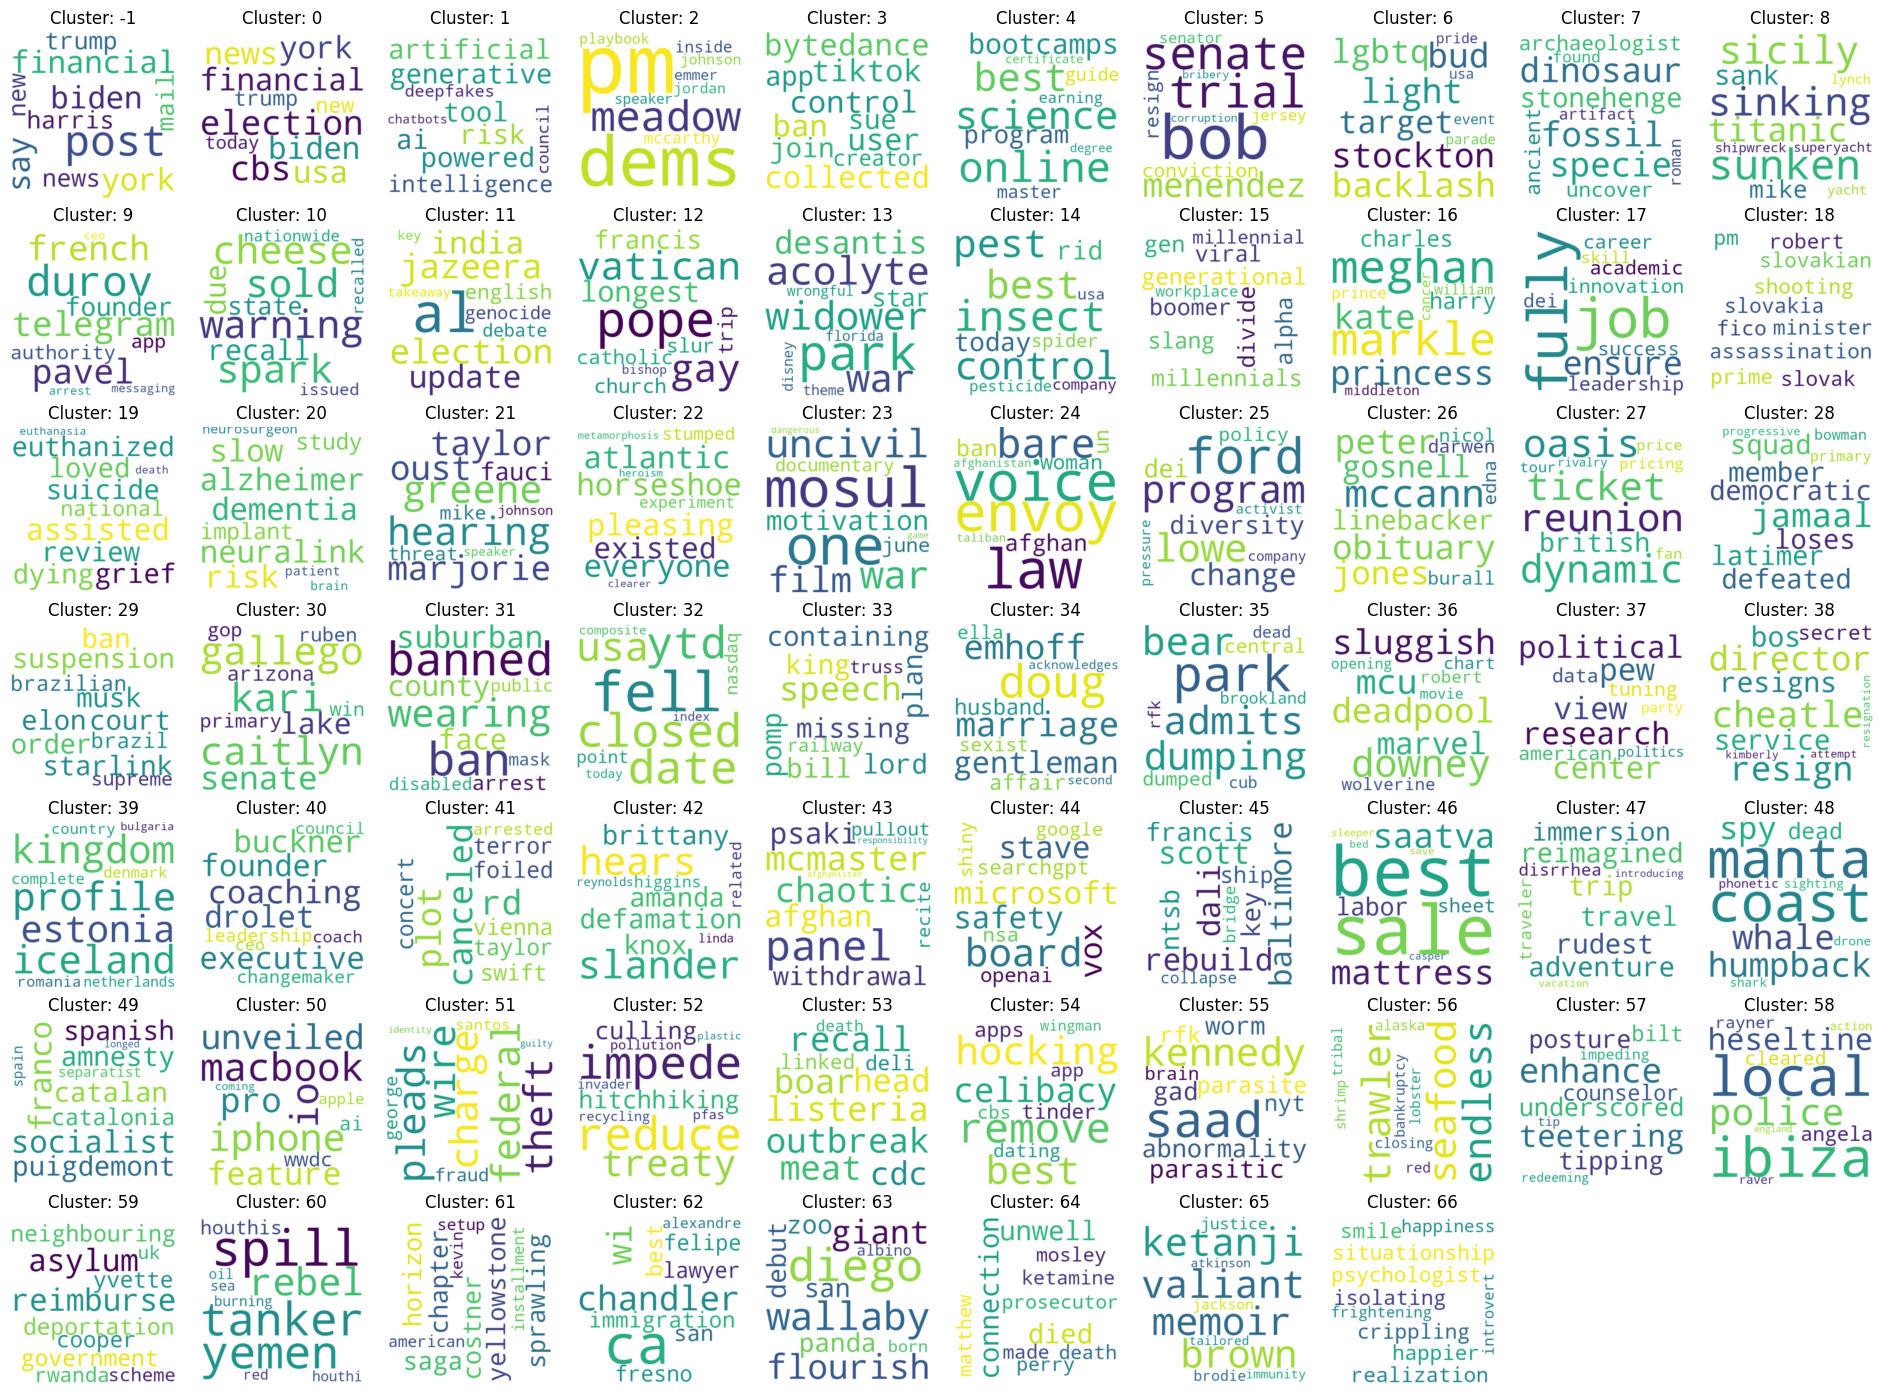

In [40]:
# Get top 20 words in each topic for visualization
# Extract the top 20 words for each topic
top_n = 20
top_words = {}

# Retrieve the topic-word mappings from the BERTopic model
topic_word_mappings = topic_model.get_topics()

for topic_id, topic_words in topic_word_mappings.items():
    # Get the top N words for each topic (sorted by importance)
    top_words[topic_id] = [word for word, _ in topic_words[:top_n]]

num_topics = len(top_words)
num_rows = math.ceil(num_topics / 10)  # 10 columns per row
num_cols = 10

# Create the subplots grid dynamically based on the number of topics
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(19, 14))
axes = axes.flatten()  # Flatten for easier indexing

num_clusters = len(top_words)
if num_clusters == 1:  # If only 1 cluster, make `axes` iterable
    axes = [axes]

for i, (cluster_label, words) in enumerate(top_words.items()):
    # Create word frequency dictionary
    word_freqs = {word: words.count(word) for word in set(words)}
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_freqs)
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Cluster: {cluster_label}", fontsize=12)

# Remove unused axes 
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


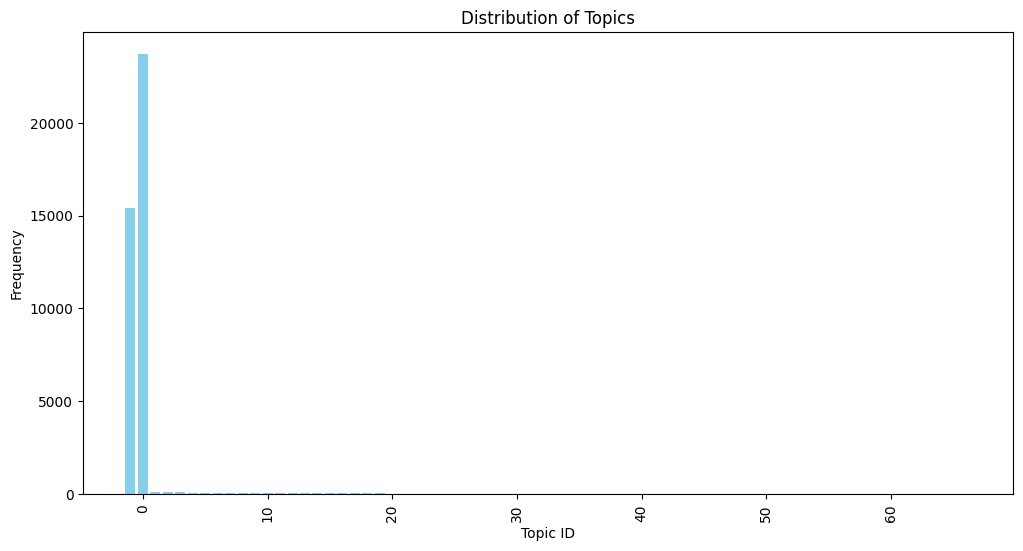

In [41]:
from collections import Counter

# Count the frequency of each topic
topic_counts = Counter(topics)

# Prepare data for the bar chart
topic_labels = list(topic_counts.keys())
topic_frequencies = list(topic_counts.values())

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(topic_labels, topic_frequencies, color='skyblue')
plt.xlabel('Topic ID')
plt.ylabel('Frequency')
plt.title('Distribution of Topics')
plt.xticks(rotation=90)
plt.show()